In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel('Watermelon.xlsx')
data = data.set_index('Year') #연도를 인덱스로 사용
data.columns = ['logQ', 'logH', 'logP', 'logPC', 'logPV', 'logW', 'logN', 'logYN', 'logPF'] #특수문자 없게 칼럼명 변화
data = data.dropna() #결측치 삭제
data

,logQ,logH,logP,logPC,logPV,logW,logN,logYN,logPF
Year,,,,,,,,,
1930,1.932,1.902,2.068,0.976,0.367,1.462,2.090,2.781,1.101
1931,1.892,1.882,2.004,0.753,1.184,1.362,2.093,2.712,1.106
1932,1.826,1.761,1.897,0.814,1.124,1.230,2.096,2.591,1.129
1933,1.751,1.741,1.968,1.007,0.993,1.204,2.099,2.561,1.149
1934,1.779,1.778,2.017,1.092,0.641,1.267,2.102,2.614,1.140
1935,1.822,1.805,1.982,1.045,0.822,1.290,2.104,2.662,1.177
1936,1.796,1.793,2.107,1.092,0.824,1.301,2.108,2.713,1.174
1937,1.851,1.835,2.025,0.925,0.903,1.352,2.110,2.741,1.175
1938,1.850,1.825,2.037,0.934,1.322,1.342,2.113,2.704,1.196


2.1
결측치를 처리하는 방법은 크게
1. 결측치가 존재하는 행이나 열을 삭제한다
2. 결측치를 0으로 처리한다.
3. 이미 존재하는 값들의 평균으로 결측치를 대체한다.
이와 같은 방법들이 있다. 해당 데이터와 같은 경우 가장 마지막 행인 1951행의 데이터에만 결측치가 존재하므로 이 행만 삭제하는 방법을 택했다. 마지막 행 하나를 삭제하는 것이 회귀분석에서 유의한 영향을 끼칠 것이라 생각하기 어렵다. 만일 결측치를 0으로 처리했다면 이는 사실상 outlier의 역할을 했을 것이므로 적절하지 못하다. 해당 데이터는 Time Series 형태이므로 non-stationarity일 수 있다. 따라서 평균값으로 결측치를 대체하는 것 보단 아예 마지막 행 하나를 삭제하는 것이 더 합리적이라 판단했다.

,Features,VIF
0,logQ,25548.374551
1,logH,18354.228778
2,logP,5876.730999
3,logPC,221.815877
4,logPV,17.354092
5,logW,3732.282447
6,logN,18725.343688
7,logYN,9260.945944
8,logPF,1627.301152


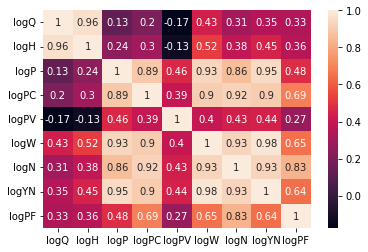

In [4]:
#2.2
sns.heatmap(data.corr(), annot=True)
data.columns
def vif_func(data): #VIF 관측 함수 생성
    vif = pd.DataFrame()
    vif['Features'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i)
                 for i in range(data.shape[1])]
    return vif
vif_func(data)

In [5]:
vif_func(data.drop(['logQ'], axis = 1)) #독립 변수들만의 VIF 관측

,Features,VIF
0,logH,5936.203894
1,logP,3766.652835
2,logPC,207.136016
3,logPV,16.839348
4,logW,2332.840696
5,logN,12826.651614
6,logYN,9260.944646
7,logPF,1391.246089


In [6]:
#3.1
result = adfuller(data['logQ']) #unit root 검증
print('ADF statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('observation: %d' %result[3])
print('Critical Values')
for key, value in result[4].items():
    print('%s: %f' %(key, value))

ADF statistic: -2.540638
p-value: 0.105897
observation: 20
Critical Values
1%: -3.809209
5%: -3.021645
10%: -2.650713


p-value>0.05 이므로 유의 수준 5%에서 non_stationarity 하다는 귀무가설을 기각할 수 없다.

In [7]:
data_pro1 = data.copy(); data_pro2 = data.copy(); data_pro3 = data.copy(); data_ad = data.copy(); data_ult = data.copy()
#몇가지 시행을 위해 DataFrame deepcopy
data_pro1['inter_c'] = 1
data_pro1.loc[1930:1934, 'inter_c'] = 0 #data_pro1 = cotton acreage allotment program 관한 상수항 더미변수 반영 데이터
data_pro2['inter_bw'] = 0
data_pro2.loc[1940:1946, 'inter_bw'] = 1 #data_pro2 = 2차 세계대전 발발 관한 상수항 더미변수 반영 데이터
data_pro3['inter_aw'] = 0
data_pro3.loc[1940:, 'inter_aw'] = 1 #data_pro3 = 2차 세계대전 발발 및 전후 경제상황 고려한 상수항 더미변수 반영 데이터
data_ult['inter_c'] = data_pro1['inter_c']; data_ult['inter_bw'] = data_pro2['inter_bw']
#data_ult = cotton acreage allotment program 및 세계대전 발발 동시 고려 상수항 더미변수 반영 데이터

data_ad['logPC'] = data_ad['logPC']*data_pro1['inter_c'] #data_ad = cotton acreage allotment program 관한 상수항 회귀모수 반영 데이터
data_ult

,logQ,logH,logP,logPC,logPV,logW,logN,logYN,logPF,inter_c,inter_bw
Year,,,,,,,,,,,
1930,1.932,1.902,2.068,0.976,0.367,1.462,2.090,2.781,1.101,0,0
1931,1.892,1.882,2.004,0.753,1.184,1.362,2.093,2.712,1.106,0,0
1932,1.826,1.761,1.897,0.814,1.124,1.230,2.096,2.591,1.129,0,0
1933,1.751,1.741,1.968,1.007,0.993,1.204,2.099,2.561,1.149,0,0
1934,1.779,1.778,2.017,1.092,0.641,1.267,2.102,2.614,1.140,0,0
1935,1.822,1.805,1.982,1.045,0.822,1.290,2.104,2.662,1.177,1,0
1936,1.796,1.793,2.107,1.092,0.824,1.301,2.108,2.713,1.174,1,0
1937,1.851,1.835,2.025,0.925,0.903,1.352,2.110,2.741,1.175,1,0
1938,1.850,1.825,2.037,0.934,1.322,1.342,2.113,2.704,1.196,1,0


3.2.1
공급함수는 Q(생산량)에 관한 설명변수 P(가격)의 함수이고 역공급함수는 P(가격)에 관한 설명변수 Q(생산량)의 함수이다.
공급함수를 구하는 것이 일반적이긴 하나 농산물의 경우 수확 이전에 재배 면적당 거래 가격을 미리 정해놓는 계약을 하는 경우가 많아
생산량이 가격을 좌지우지 하는 경우가 많다. 따라서 농산물의 경우 역공급함수를 추정하는 것이 합리적일 수 있다.
하지만 해당 과제에 경우 logQ를 종속변수로 설정하였으므로 공급함수를 추정하기로 한다.

In [20]:
#3.3
formula = 'logQ ~ logP + logPV + logPC + logW' #더미 변수 없이 추정한 회귀식
model = smf.ols(formula, data = data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     74.99
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           4.51e-10
Time:                        15:07:03   Log-Likelihood:                 62.741
No. Observations:                  21   AIC:                            -113.5
Df Residuals:                      15   BIC:                            -107.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5215      0.221      2.361      0.032       0.051       0.992
logH           0.7720      0.117      6.609      0.000       0.523       1.021
logP          -0.1617      0.053     -3.077      0.008      -0.274      -0.050
logPV         -0.0063      0.011     -0.588      0.565      -0.029       0.017
logPC         -0.0458      0.035     -1.320      0.206      -0.120       0.028
logW           0.2178      0.078      2.800      0.013       0.052       0.384
==============================================================================
Omnibus:                        0.184   Durbin-Watson:                   2.725
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.119
Skew:                           0.141   Prob(JB):                        0.942
Kurtosis:                       2.763   Cond. No.                         317.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3.2.2
공급함수의 결정요인은 크게 생산비용, 가격, 대체재의 유무, 미래에 대한 기대, 필수재의 소비비중 등을 들 수 있다.
가격 = logP, 대체재 = logPV, 필수재의 소비비중 = logPC(면화생산물, '의'와 관련된 것이므로), 생산비용 = logW, 미래에 대한 기대 = logYN
으로 설정한다.
수박의 경우 야채로 구분되긴 하나 그 용도는 사실상 과일과 같은 만큼(수프에 당근, 양파는 넣지만 수박은 넣지 않으니) 야채 가격을 대체재의 설명변수로 넣는 것이 과연 합리적일까 의구심이 들었다. ols를 확인해보니 설명력과 수정된 설명력 모두 0.8이상의 높은 값을 보여주는 와중에 logPV의 p-value가 0.119로 0.1보다도 큰 것을 확인할 수 있다. 하지만 Omitted Variable Problem은 unbiased를 유발하고, logPV를 빼고 회귀식을 돌려본 결과, adj R2는 오히려 낮아지므로 빼진 않기로한다. 그러나 logYN의 경우 p-value가 0.903으로 굉장히 높게 나온데다가 해당 변수를 빼고 회귀분석을 진행했을때 설명력이 오히려 높아지므로 logYN은 미래에 대한 기대를 반영하는 설명 변수가 아니라고 판단, 분석 시 제외하기로 했다. 
이후 설명변수는 logP, logPC, logPV, logW, 로 한다.

3.2.3
적응적 기대는 unit root가 있는 모형과 비슷하다. 과거의 데이터, 추세를 근거로 미래의 결과를 예측하는 것이 적응적 기대라고 할 수 있다.
합리적 기대는 이용 가능한 모든 정보를 사용하여 합리적인 추론 방식을 통해 미래를 예측하는 방법이다.
이러한 적응적 기대, 혹은 합리적 기대가 반영된 변수는 logH라고 할 수 있다. 재배량을 결정하는 것은 미래에 대한 기대이기 때문이다. 직관적으로 종속변수 logQ에 가장 큰 영향을 미치는 것은 logH일 것이다. 하지만 logH를 설명변수에 넣어버리면 partial effect 가 중첩되어 모형의 설명력이 과대평가 될 우려가 있다. 해서 설명변수에 logH는 제외하기로 하였다.

In [21]:
result = adfuller(data['logH']) #unit root 검증
print('ADF statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('observation: %d' %result[3])
print('Critical Values')
for key, value in result[4].items():
    print('%s: %f' %(key, value))

ADF statistic: 2.449193
p-value: 0.999032
observation: 12
Critical Values
1%: -4.137829
5%: -3.154972
10%: -2.714477


위는 logH의 정상성 확인이다. p-value가 무려 0.99가 나오므로 정상성을 가진다고 할 수 없으며 적응적 기대에 영향을 많이 받음을 알 수 있다. 

In [18]:
#3.4.2
formula = 'logQ ~ logP + logPC + logPV + logW + inter_c' #cotton acreage allotment program 관한 상수항 더미변수 반영한 회귀분석 모델
model = smf.ols(formula, data = data_pro1)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     17.61
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           8.36e-06
Time:                        14:03:13   Log-Likelihood:                 48.768
No. Observations:                  21   AIC:                            -85.54
Df Residuals:                      15   BIC:                            -79.27
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9745      0.069     28.550      0.000       1.827       2.122
logP          -0.4221      0.071     -5.976      0.000      -0.573      -0.272
logPC         -0.1506      0.063     -2.392      0.030      -0.285      -0.016
logPV         -0.0353      0.020     -1.784      0.095      -0.077       0.007
logW           0.6682      0.077      8.720      0.000       0.505       0.832
inter_c        0.0127      0.018      0.711      0.488      -0.025       0.051
==============================================================================
Omnibus:                        0.675   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.087
Skew:                           0.142   Prob(JB):                        0.957
Kurtosis:                       3.137   Cond. No.                         59.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

가변수를 반영하자 설명력이 오히려 떨어졌다. 가변수항의 p-value도 0.488로 크게 유의성을 가진다고 보기 어렵다.

In [19]:
formula = 'logQ ~ logP + logPC + logW + inter_c' #위 모델에서 logPV만 제외한 분석모델
model = smf.ols(formula, data = data_pro1)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     18.67
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           7.13e-06
Time:                        14:03:36   Log-Likelihood:                 46.747
No. Observations:                  21   AIC:                            -83.49
Df Residuals:                      16   BIC:                            -78.27
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9863      0.073     27.065      0.000       1.831       2.142
logP          -0.4522      0.073     -6.185      0.000      -0.607      -0.297
logPC         -0.1467      0.067     -2.186      0.044      -0.289      -0.004
logW           0.6790      0.081      8.338      0.000       0.506       0.852
inter_c        0.0072      0.019      0.383      0.707      -0.033       0.047
==============================================================================
Omnibus:                        1.803   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.096
Skew:                           0.220   Prob(JB):                        0.578
Kurtosis:                       1.971   Cond. No.                         55.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

logPV의 t value가 높진 않지만 이를 제외할 시, 설명력이 다소 떨어지는걸 볼 수 있다.

In [22]:
formula = 'logQ ~ logP + logPC + logPV + logW' #cotton acreage allotment program 실시 여부를 DataFrame에 직접 반영한 모델
model = smf.ols(formula, data = data_ad)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     15.89
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           1.98e-05
Time:                        15:20:23   Log-Likelihood:                 45.374
No. Observations:                  21   AIC:                            -80.75
Df Residuals:                      16   BIC:                            -75.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0189      0.084     23.931      0.000       1.840       2.198
logP          -0.4605      0.078     -5.903      0.000      -0.626      -0.295
logPC         -0.0032      0.020     -0.160      0.875      -0.045       0.039
logPV         -0.0322      0.023     -1.416      0.176      -0.080       0.016
logW           0.5861      0.079      7.460      0.000       0.420       0.753
==============================================================================
Omnibus:                        4.230   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                1.609
Skew:                           0.242   Prob(JB):                        0.447
Kurtosis:                       1.733   Cond. No.                         57.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

설명력이 다소 낮아졌지만 logPC의 t-value가 치솟은걸 볼 수 있다. 사실 검색을 해봐도 가변수를 상수항으로 쓰는 가변수 처리방법만 보이고 회귀모수에 곱해 처리하는 방법은 보이지 않아 한 번 시도해봤는데 사실 이는 회귀모수에 가변수 처리를 한 것도 아니며 인위적으로 outlier인 데이터들만 만들어낸 것과 다르지 않았다. 이러한 방식의 데이터 전처리는 합리적이지 못함을 알 수 있다.

In [25]:
#3.4.2
formula = 'logQ ~ logP + logPC + logPV + logW + inter_bw' #2차 세계대전 발발 관한 상수항 더미변수 반영한 분석모델
model = smf.ols(formula, data = data_pro2)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     25.78
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           7.26e-07
Time:                        15:21:14   Log-Likelihood:                 52.275
No. Observations:                  21   AIC:                            -92.55
Df Residuals:                      15   BIC:                            -86.28
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0598      0.068     30.212      0.000       1.915       2.205
logP          -0.5199      0.072     -7.241      0.000      -0.673      -0.367
logPC         -0.1407      0.052     -2.706      0.016      -0.252      -0.030
logPV         -0.0404      0.017     -2.412      0.029      -0.076      -0.005
logW           0.7505      0.073     10.283      0.000       0.595       0.906
inter_bw       0.0381      0.015      2.580      0.021       0.007       0.070
==============================================================================
Omnibus:                        0.291   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.865   Jarque-Bera (JB):                0.176
Skew:                           0.195   Prob(JB):                        0.916
Kurtosis:                       2.779   Cond. No.                         71.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

2차 세계대전의 발발 연도는 1939년, 미국이 2차세계대전에 참전한건 1941년으로 참전이 2년 늦긴 했지만 미국은 이미 1939년부터 현금을 통해 유럽에 군수지원을 하고 있었다. 우크라이나-러시아 전쟁을 봐도 알 수 있듯이 두 국가간의 전쟁만으로도 공급망 교란 등 전세계 경제에 영향을 주고 있는데 단순히 미국이 참전을 안했으므로 '미국의 참전 이후에야 미국 경제가 영향을 받았을 것이다'라는 추론은 합리적이지 못하다. 더군다나 전쟁 발발년도와 참전년도는 2년 밖에 차이가 나지 않아 이 2개 관측값 차이가 크게 유의하다고 보기도 어렵다고 생각했다. 해서 전쟁 발발 이후 년도인 1940년도부터 가변수를 반영했다.

In [29]:
formula = 'logQ ~ logP + logPC + logPV + logW + inter_aw'
model = smf.ols(formula, data = data_pro3)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     18.39
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           6.38e-06
Time:                        16:31:43   Log-Likelihood:                 49.159
No. Observations:                  21   AIC:                            -86.32
Df Residuals:                      15   BIC:                            -80.05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0257      0.089     22.791      0.000       1.836       2.215
logP          -0.4301      0.070     -6.132      0.000      -0.580      -0.281
logPC         -0.1620      0.064     -2.546      0.022      -0.298      -0.026
logPV         -0.0421      0.021     -1.999      0.064      -0.087       0.003
logW           0.6575      0.075      8.783      0.000       0.498       0.817
inter_aw       0.0269      0.026      1.046      0.312      -0.028       0.082
==============================================================================
Omnibus:                        1.402   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                0.479
Skew:                           0.347   Prob(JB):                        0.787
Kurtosis:                       3.259   Cond. No.                         62.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

미국이 진정 패권국가로 부상하게 된 계기는 2차 세계대전 이후였다. '2차 세계대전 특수'가 전후에도 이어졌을 것이라고 생각해서 전쟁 발발 이후 1950 인덱스 끝까지 가변수를 대입해 보았다. 하지만 설명력과 F-value 모두 위의 모형보다 낮아진걸 볼 수 있다. 종전까지만 가변수를 반영한 모델이 더 나은 모델이라고 할 수 있다.

In [30]:
formula = 'logQ ~ logP + logPC + logPV + logW + inter_c + inter_bw'
model = smf.ols(formula, data = data_ult)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     20.27
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           3.72e-06
Time:                        16:42:08   Log-Likelihood:                 52.375
No. Observations:                  21   AIC:                            -90.75
Df Residuals:                      14   BIC:                            -83.44
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0622      0.071     29.238      0.000       1.911       2.213
logP          -0.5203      0.074     -7.034      0.000      -0.679      -0.362
logPC         -0.1452      0.055     -2.642      0.019      -0.263      -0.027
logPV         -0.0413      0.017     -2.370      0.033      -0.079      -0.004
logW           0.7510      0.075      9.986      0.000       0.590       0.912
inter_c        0.0058      0.016      0.366      0.720      -0.028       0.040
inter_bw       0.0371      0.015      2.395      0.031       0.004       0.070
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.047
Skew:                           0.067   Prob(JB):                        0.977
Kurtosis:                       2.811   Cond. No.                         73.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

cotton acreage allotment program과 2차 세계대전에 관한 가변수를 동시에 반영한 모델이다

In [ ]:
cotton acreage allotment program를 가변수 상수항으로 반영하는건 크게 유의하지 못한 것 같다.
반면 2차 세계대전 가변수 상수항은 유의성을 가진다.